In [ ]:
!pip install matplotlib pandas requests python-dotenv

In [7]:
import time
from datetime import datetime
import pandas as pd
import requests

# --- помощники ---

def month_ranges(begin: str, end: str):
    """
    Возвращает список пар (start, end) по месяцам в формате YYYY-MM-DD.
    Конец интервала включительно. Работает даже если begin/end внутри месяца.
    """
    b = pd.to_datetime(begin).normalize()
    e = pd.to_datetime(end).normalize()

    # месячные старты (1-е числа)
    starts = pd.date_range(b, e, freq="MS")
    if len(starts) == 0 or starts[0] != b:
        starts = starts.insert(0, b)

    # для каждого старта месяц заканчивается за день до следующего старта; последний — e
    ends = list(starts[1:] - pd.Timedelta(days=1)) + [e]

    pairs = []
    for s, t in zip(starts, ends):
        if s > e:
            break
        t = min(t, e)
        if s <= t:
            pairs.append((s.strftime("%Y-%m-%d"), t.strftime("%Y-%m-%d")))
    return pairs

def fetch_json_with_retry(url: str, params: dict, retries: int = 4, timeout=(5, 120), backoff=2.0):
    """GET с ретраями и экспоненциальной паузой."""
    last_err = None
    for i in range(retries):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            r.raise_for_status()
            return r.json()
        except Exception as e:
            last_err = e
            # небольшая пауза и повтор
            time.sleep(backoff ** i)
    raise last_err

# --- загрузка чанкована по месяцам ---

def fetch_table(api_url_base: str, route: str, begin: str, end: str):
    """Собираем данные route ('visits' или 'registrations') помесячно и склеиваем в DataFrame."""
    frames = []
    for b, e in month_ranges(begin, end):
        data = fetch_json_with_retry(f"{api_url_base}/{route}", {"begin": b, "end": e}, timeout=(5, 180))
        if not data:
            continue
        frames.append(pd.DataFrame(data))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

# --- собственно загрузка из API ---

print("Загружаю visits по месяцам…")
visits_api = fetch_table(API_URL, "visits", DATE_BEGIN, DATE_END) \
    .rename(columns={"visit_id": "uuid", "datetime": "date"})
visits_api["date"] = pd.to_datetime(visits_api["date"], errors="coerce")

# нормализация
for c in ["uuid", "platform", "user_agent"]:
    if c in visits_api.columns:
        visits_api[c] = visits_api[c].astype(str).str.strip().str.lower()

print("Загружаю registrations по месяцам…")
regs_api = fetch_table(API_URL, "registrations", DATE_BEGIN, DATE_END) \
    .rename(columns={"datetime": "date"})
regs_api["date"] = pd.to_datetime(regs_api["date"], errors="coerce")

for c in ["user_id", "email", "platform", "registration_type"]:
    if c in regs_api.columns:
        regs_api[c] = regs_api[c].astype(str).str.strip().str.lower()

print("Готово:", visits_api.shape, regs_api.shape)

Загружаю visits по месяцам…
Загружаю registrations по месяцам…
Готово: (255028, 4) (21094, 5)


In [8]:
# Преобразуем колонки к удобному виду и собираем данные из API
params = {"begin": DATE_BEGIN, "end": DATE_END}

# --- Визиты ---
resp_v = requests.get(f"{API_URL}/visits", params=params, timeout=60)
resp_v.raise_for_status()
visits_api = pd.DataFrame(resp_v.json()).rename(columns={"visit_id": "uuid", "datetime": "date"})
visits_api["date"] = pd.to_datetime(visits_api["date"], errors="coerce")
for c in ["uuid", "platform", "user_agent"]:
    visits_api[c] = visits_api[c].astype(str).str.strip().str.lower()

# --- Регистрации ---  <-- ЭТОГО БЛОКА НЕ ХВАТАЛО
resp_r = requests.get(f"{API_URL}/registrations", params=params, timeout=60)
resp_r.raise_for_status()
regs_api = pd.DataFrame(resp_r.json()).rename(columns={"datetime": "date"})
regs_api["date"] = pd.to_datetime(regs_api["date"], errors="coerce")
for c in ["user_id", "email", "platform", "registration_type"]:
    regs_api[c] = regs_api[c].astype(str).str.strip().str.lower()

# === 1) Готовим визиты и регистрации (работаем от visits_api / regs_api) ===
visits = visits_api.copy()
regs   = regs_api.copy()

# исключаем ботов (по user_agent) из расчёта визитов
visits["is_bot"] = visits["user_agent"].str.contains("bot", na=False)
visits_nobots = visits.loc[~visits["is_bot"]].copy()

# последний визит на пользователя
visits_nobots = visits_nobots.sort_values("date")
last_visits = (
    visits_nobots.groupby("uuid", as_index=False)
    .agg({"date": "max"})
)
visits_last = last_visits.merge(
    visits_nobots[["uuid", "date", "platform"]],
    on=["uuid", "date"],
    how="left"
)

# группируем по дням/платформам
visits_last["date_group"] = visits_last["date"].dt.date
visits_daily = (
    visits_last.groupby(["date_group", "platform"], as_index=False)
    .agg(visits=("uuid", "count"))
)

regs["date_group"] = regs["date"].dt.date
regs_daily = (
    regs.groupby(["date_group", "platform"], as_index=False)
    .agg(registrations=("user_id", "count"))
)

# объединяем и считаем конверсию
merged = (
    visits_daily.merge(regs_daily, on=["date_group", "platform"], how="outer")
    .fillna({"visits": 0, "registrations": 0})
)
merged["visits"] = merged["visits"].astype(int)
merged["registrations"] = merged["registrations"].astype(int)
merged["conversion"] = (
    merged["registrations"] / merged["visits"].replace(0, pd.NA) * 100
).round(2).fillna(0)

# сохраняем conversion.json (требование автотестов)
merged[["date_group", "platform", "visits", "registrations", "conversion"]].to_json("./conversion.json")
print("saved: ./conversion.json")

# === 2) Ежедневные итоги и объединение с рекламой ===
try:
    ads = pd.read_csv("./ads.csv")
    ads.columns = [c.strip().lower() for c in ads.columns]
    ads["date"] = pd.to_datetime(ads["date"], errors="coerce")
    ads["date_group"] = ads["date"].dt.date
    ads_grouped = ads.groupby(["date_group", "utm_campaign"], as_index=False).agg(cost=("cost", "sum"))
except FileNotFoundError:
    ads_grouped = pd.DataFrame(columns=["date_group", "utm_campaign", "cost"])

conv_daily = merged.groupby("date_group", as_index=False)[["visits", "registrations"]].sum()

final = conv_daily.merge(ads_grouped, on="date_group", how="left")
final["utm_campaign"] = final["utm_campaign"].fillna("none")
final["cost"] = final["cost"].fillna(0).astype(float)

# сохраняем ads.json (требование автотестов)
final[["date_group", "visits", "registrations", "cost", "utm_campaign"]].to_json("./ads.json")
print("saved: ./ads.json")

merged.head(), final.head()


saved: ./conversion.json
saved: ./ads.json


(   date_group platform  visits  registrations  conversion
 0  2023-03-01  android      75             61       81.33
 1  2023-03-01      ios      22             18       81.82
 2  2023-03-01      web     279              8        2.87
 3  2023-03-02  android      67             59       88.06
 4  2023-03-02      ios      31             24       77.42,
    date_group  visits  registrations                utm_campaign   cost
 0  2023-03-01     376             87  advanced_algorithms_series  212.0
 1  2023-03-02     613            106  advanced_algorithms_series  252.0
 2  2023-03-03     683            107  advanced_algorithms_series  202.0
 3  2023-03-04     647            159  advanced_algorithms_series  223.0
 4  2023-03-05     707            115  advanced_algorithms_series  265.0)

In [9]:
print("Visits shape:", visits.shape)
print("Registrations shape:", regs.shape)

print("Доля дубликатов в visits:", visits.duplicated().mean())
print("Доля дубликатов в registrations:", regs.duplicated().mean())

Visits shape: (263459, 5)
Registrations shape: (21836, 6)
Доля дубликатов в visits: 0.0
Доля дубликатов в registrations: 0.0


In [10]:
print("Пропуски в visits:")
print(visits.isna().mean())

print("\nПропуски в registrations:")
print(regs.isna().mean())

Пропуски в visits:
uuid          0.0
platform      0.0
user_agent    0.0
date          0.0
is_bot        0.0
dtype: float64

Пропуски в registrations:
date                 0.0
user_id              0.0
email                0.0
platform             0.0
registration_type    0.0
date_group           0.0
dtype: float64


In [13]:
print("Visits by platform:")
print(visits["platform"].value_counts())

print("\nRegistrations by platform:")
print(regs["platform"].value_counts())

print("\nRegistration types:")
print(regs["registration_type"].value_counts())

Visits by platform:
platform
web        954
android     27
ios         19
Name: count, dtype: int64

Registrations by platform:
platform
android    517
web        265
ios        218
Name: count, dtype: int64

Registration types:
registration_type
email     446
google    303
apple     178
yandex     73
Name: count, dtype: int64


In [11]:
import pandas as pd
import requests

BASE = "https://data-charts-api.hexlet.app"
BEGIN = "2023-03-01"
END   = "2023-09-01"
params = {"begin": BEGIN, "end": END}
params

{'begin': '2023-03-01', 'end': '2023-09-01'}

In [13]:
print("visits_api:", visits_api.shape, 
      "| nulls:", visits_api.isna().mean().round(4).to_dict())
print("regs_api:", regs_api.shape, 
      "| nulls:", regs_api.isna().mean().round(4).to_dict())

print("\nVisits platforms:\n", visits_api["platform"].value_counts().head(10))
print("\nRegs platforms:\n", regs_api["platform"].value_counts().head(10))
print("\nRegs types:\n", regs_api["registration_type"].value_counts().head(10))


visits_api: (263459, 4) | nulls: {'uuid': 0.0, 'platform': 0.0, 'user_agent': 0.0, 'date': 0.0}
regs_api: (21836, 5) | nulls: {'date': 0.0, 'user_id': 0.0, 'email': 0.0, 'platform': 0.0, 'registration_type': 0.0}

Visits platforms:
 platform
web        236301
android     13972
bot          7382
ios          5804
Name: count, dtype: int64

Regs platforms:
 platform
android    10582
web         6877
ios         4377
Name: count, dtype: int64

Regs types:
 registration_type
email     8996
google    7105
apple     4006
yandex    1729
Name: count, dtype: int64


In [14]:
# убираем визиты ботов
visits_clean = visits_api[~visits_api["user_agent"].str.contains("bot", case=False, na=False)].copy()

# для каждого uuid оставим только последний визит
visits_clean = visits_clean.sort_values("date").drop_duplicates("uuid", keep="last")

# агрегируем: количество визитов по дате и платформе
visits_grouped = visits_clean.groupby([visits_clean["date"].dt.date, "platform"]).size().reset_index(name="visits")

visits_grouped = visits_grouped.rename(columns={"date": "date_group"})
visits_grouped.head()

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31


In [15]:
# агрегируем регистрации: количество по дате и платформе
regs_grouped = regs_api.groupby([regs_api["date"].dt.date, "platform"]).size().reset_index(name="registrations")

regs_grouped = regs_grouped.rename(columns={"date": "date_group"})
regs_grouped.head()

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


In [17]:
# объединение по дате и платформе
merged = pd.merge(visits_grouped, regs_grouped, on=["date_group", "platform"], how="outer")

# если где-то нет регистраций или визитов → ставим 0
merged = merged.fillna(0)

# конверсия = (registrations / visits * 100)
merged["conversion"] = (merged["registrations"] / merged["visits"] * 100).round(2)

# сортируем по дате
merged = merged.sort_values("date_group").reset_index(drop=True)

merged.head(10)


,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42
5,2023-03-02,web,515,23,4.47
6,2023-03-03,android,26,22,84.62
7,2023-03-03,ios,40,34,85.00
8,2023-03-03,web,617,51,8.27
9,2023-03-04,android,94,77,81.91


In [18]:
# Убираем ботов и берём последний визит на uuid
visits_clean = visits_api[~visits_api["user_agent"].str.contains("bot", case=False, na=False)].copy()
visits_clean = visits_clean.sort_values("date").drop_duplicates("uuid", keep="last")

# Агрегации визитов и регистраций по дате и платформе
vg = visits_clean.groupby([visits_clean["date"].dt.date, "platform"]).size().reset_index(name="visits")
vg = vg.rename(columns={"date": "date_group"})

rg = regs_api.groupby([regs_api["date"].dt.date, "platform"]).size().reset_index(name="registrations")
rg = rg.rename(columns={"date": "date_group"})

# Итоговый датафрейм с конверсией
merged = pd.merge(vg, rg, on=["date_group", "platform"], how="outer").fillna(0)
merged["conversion"] = (merged["registrations"] / merged["visits"] * 100).replace([float("inf")], 0).round(2)

# Сводка по дням без платформ (для рекламы)
conv_daily = merged.groupby("date_group", as_index=False)[["visits","registrations"]].sum()

merged.head(), conv_daily.head()

(   date_group platform  visits  registrations  conversion
 0  2023-03-01  android      75             61       81.33
 1  2023-03-01      ios      22             18       81.82
 2  2023-03-01      web     279              8        2.87
 3  2023-03-02  android      67             59       88.06
 4  2023-03-02      ios      31             24       77.42,
    date_group  visits  registrations
 0  2023-03-01     376             87
 1  2023-03-02     613            106
 2  2023-03-03     683            107
 3  2023-03-04     647            159
 4  2023-03-05     707            115)

In [19]:
ads = pd.read_csv("./ads.csv")
ads.columns = [c.strip().lower() for c in ads.columns]
ads["date"] = pd.to_datetime(ads["date"], errors="coerce")
ads["date_group"] = ads["date"].dt.date

ads_grouped = ads.groupby(["date_group","utm_campaign"], as_index=False)["cost"].sum()

# Объединение с дневной статистикой
final = conv_daily.merge(ads_grouped, on="date_group", how="left")
final["utm_campaign"] = final["utm_campaign"].fillna("none")
final["cost"] = final["cost"].fillna(0)

final.head()

,date_group,visits,registrations,utm_campaign,cost
0,2023-03-01,376,87,advanced_algorithms_series,212.0
1,2023-03-02,613,106,advanced_algorithms_series,252.0
2,2023-03-03,683,107,advanced_algorithms_series,202.0
3,2023-03-04,647,159,advanced_algorithms_series,223.0
4,2023-03-05,707,115,advanced_algorithms_series,265.0


In [20]:
merged[["date_group","platform","visits","registrations","conversion"]].to_json("./conversion.json")

In [21]:
# 1) читаем файл рекламы
# если вдруг у тебя разделитель ; (точка с запятой), смени на: pd.read_csv("../data/raw/ads.csv", sep=";")
ads = pd.read_csv("./ads.csv")   # файл лежит рядом с ноутбуком
ads.columns = [c.strip().lower() for c in ads.columns]
ads["date"] = pd.to_datetime(ads["date"], errors="coerce")
ads["date_group"] = ads["date"].dt.date

# 2) приведение типов/колонок
# ожидаемые колонки: date, utm_source, utm_medium, utm_campaign, cost
ads.columns = [c.strip().lower() for c in ads.columns]
ads["date"] = pd.to_datetime(ads["date"], errors="coerce")
ads["date_group"] = ads["date"].dt.date

# 3) оставим только нужные поля (для задачи нам нужны дата, кампания, затраты)
ads = ads[["date_group", "utm_campaign", "cost"]]

ads.head()

,date_group,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265


In [22]:
ads_grouped = (
    ads.groupby(["date_group", "utm_campaign"], as_index=False)["cost"]
       .sum()
)
ads_grouped.head()


,date_group,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265


In [23]:
# если у тебя уже есть merged из предыдущего шага
conv_daily = merged.groupby("date_group", as_index=False)[["visits", "registrations"]].sum()
conv_daily.head()

,date_group,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,106
2,2023-03-03,683,107
3,2023-03-04,647,159
4,2023-03-05,707,115


In [25]:
final = conv_daily.merge(ads_grouped, on="date_group", how="left")

# если рекламы в этот день не было — ставим «none» и 0
final["utm_campaign"] = final["utm_campaign"].fillna("none")
final["cost"] = final["cost"].fillna(0)

# сортируем по дате
final = final.sort_values("date_group").reset_index(drop=True)
final.head(10)

,date_group,visits,registrations,utm_campaign,cost
0,2023-03-01,376,87,advanced_algorithms_series,212.0
1,2023-03-02,613,106,advanced_algorithms_series,252.0
2,2023-03-03,683,107,advanced_algorithms_series,202.0
3,2023-03-04,647,159,advanced_algorithms_series,223.0
4,2023-03-05,707,115,advanced_algorithms_series,265.0
5,2023-03-06,1291,230,advanced_algorithms_series,108.0
6,2023-03-07,1382,124,advanced_algorithms_series,165.0
7,2023-03-08,1382,151,advanced_algorithms_series,155.0
8,2023-03-09,1064,209,advanced_algorithms_series,124.0
9,2023-03-10,812,112,advanced_algorithms_series,276.0


In [27]:
final[["date_group","visits","registrations","cost","utm_campaign"]].to_json("./ads.json")
print("saved: ./ads.json")

saved: ./ads.json


In [29]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# где сохраняем (Важно: ровно ./charts)
CHARTS = Path("./charts")
CHARTS.mkdir(parents=True, exist_ok=True)

# ВОССТАНОВЛЕНИЕ ДАННЫХ (если переменных нет в памяти)
# merged: по дням и платформам (date_group, platform, visits, registrations, conversion)
try:
    merged
except NameError:
    # пересоберём из visits_api / regs_api
    # 1) визиты без ботов, последний визит на uuid
    visits_clean = visits_api[~visits_api["user_agent"].str.contains("bot", case=False, na=False)].copy()
    visits_clean = visits_clean.sort_values("date").drop_duplicates("uuid", keep="last")
    vg = visits_clean.groupby([visits_clean["date"].dt.date, "platform"]).size().reset_index(name="visits")
    vg = vg.rename(columns={"date": "date_group"})

    # 2) регистрации
    rg = regs_api.groupby([regs_api["date"].dt.date, "platform"]).size().reset_index(name="registrations")
    rg = rg.rename(columns={"date": "date_group"})

    # 3) объединяем и считаем конверсию
    merged = pd.merge(vg, rg, on=["date_group", "platform"], how="outer").fillna(0)
    merged["conversion"] = (merged["registrations"] / merged["visits"] * 100).replace([float("inf")], 0).round(2)

# сводка по дням (без платформ)
conv_daily = merged.groupby("date_group", as_index=False)[["visits","registrations"]].sum()

# final: conv_daily + реклама (date_group, visits, registrations, cost, utm_campaign)
try:
    final
except NameError:
    # читаем РОВНО из ./ads.csv (так ждут тесты)
    ads = pd.read_csv("./ads.csv")
    ads["date"] = pd.to_datetime(ads["date"], errors="coerce")
    ads["date_group"] = ads["date"].dt.date
    ads_grouped = ads.groupby(["date_group","utm_campaign"], as_index=False)["cost"].sum()
    final = conv_daily.merge(ads_grouped, on="date_group", how="left")
    final["utm_campaign"] = final["utm_campaign"].fillna("none")
    final["cost"] = final["cost"].fillna(0)

# вспомогательные функции для подписей
def annotate_bars(ax, fmt="{:,.0f}", rotation=0, fontsize=8):
    for p in ax.patches:
        h = p.get_height()
        x = p.get_x() + p.get_width()/2
        ax.text(x, h, fmt.format(h), ha="center", va="bottom", fontsize=fontsize, rotation=rotation)

def annotate_points(ax, x, y, step=7, fmt="{}", fontsize=7):
    """Подписываем каждую N-ю точку и обязательно последнюю.
    Индексируем ПО ПОЗИЦИИ (iloc), чтобы не ловить KeyError."""
    x = pd.Series(x).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    n = len(x)
    step = max(1, int(step))
    for i in range(0, n, step):
        ax.text(x.iloc[i], y.iloc[i], fmt.format(y.iloc[i]),
                fontsize=fontsize, ha="center", va="bottom")
    if n > 0:
        ax.text(x.iloc[-1], y.iloc[-1], fmt.format(y.iloc[-1]),
                fontsize=fontsize, ha="left", va="bottom")

# общие агрегаты (пригодятся для подписей)
total_visits = conv_daily["visits"].sum()
total_regs = conv_daily["registrations"].sum()

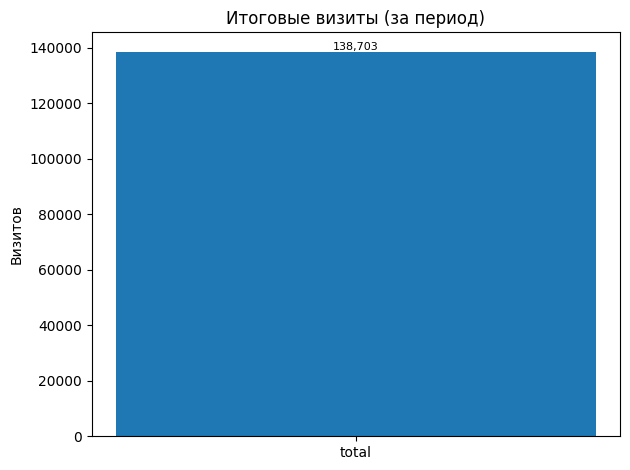

In [30]:
plt.figure()
ax = plt.gca()
bars = ax.bar(["total"], [total_visits])
ax.set_title("Итоговые визиты (за период)")
ax.set_ylabel("Визитов")
annotate_bars(ax, fmt="{:,.0f}")
plt.tight_layout()
plt.savefig(CHARTS / "visits_total.png", dpi=150)
plt.show()

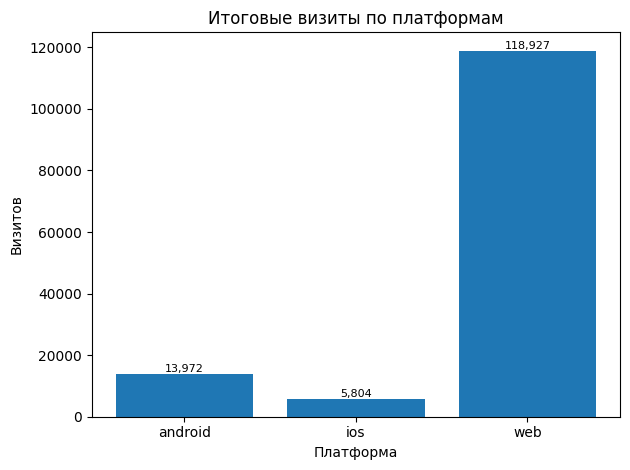

In [31]:
by_plat_vis = merged.groupby("platform", as_index=False)["visits"].sum()

plt.figure()
ax = plt.gca()
ax.bar(by_plat_vis["platform"], by_plat_vis["visits"])
ax.set_title("Итоговые визиты по платформам")
ax.set_xlabel("Платформа")
ax.set_ylabel("Визитов")
annotate_bars(ax, fmt="{:,.0f}")
plt.tight_layout()
plt.savefig(CHARTS / "visits_by_platform_total.png", dpi=150)
plt.show()

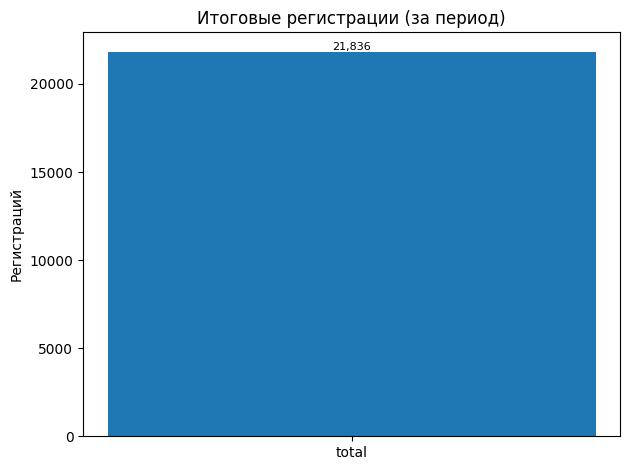

In [48]:
plt.figure()
ax = plt.gca()
ax.bar(["total"], [total_regs])
ax.set_title("Итоговые регистрации (за период)")
ax.set_ylabel("Регистраций")
annotate_bars(ax, fmt="{:,.0f}")
plt.tight_layout()
plt.savefig(CHARTS / "registrations_total.png", dpi=150)
plt.show()


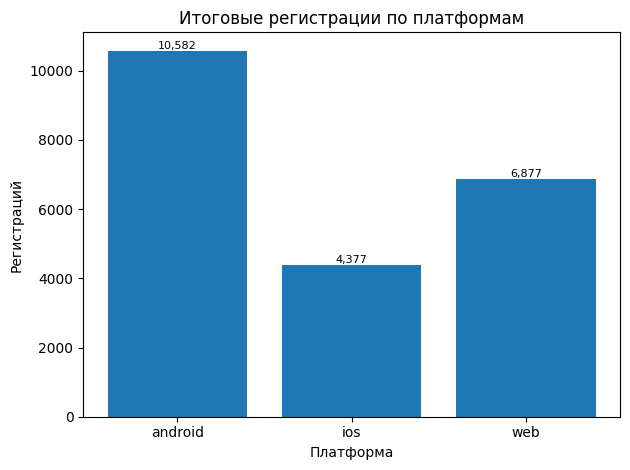

In [32]:
by_plat_regs = merged.groupby("platform", as_index=False)["registrations"].sum()

plt.figure()
ax = plt.gca()
ax.bar(by_plat_regs["platform"], by_plat_regs["registrations"])
ax.set_title("Итоговые регистрации по платформам")
ax.set_xlabel("Платформа")
ax.set_ylabel("Регистраций")
annotate_bars(ax, fmt="{:,.0f}")
plt.tight_layout()
plt.savefig(CHARTS / "registrations_by_platform_total.png", dpi=150)
plt.show()


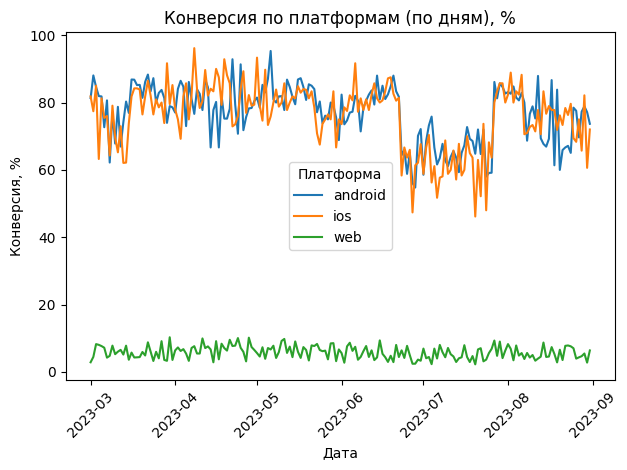

In [33]:
conv_pf = (
    merged.groupby(["date_group","platform"], as_index=False)[["visits","registrations"]].sum()
)
conv_pf["conversion"] = (conv_pf["registrations"] / conv_pf["visits"] * 100).replace([float("inf")], 0)

plt.figure()
ax = plt.gca()
for plat, sub in conv_pf.groupby("platform"):
    ax.plot(sub["date_group"], sub["conversion"], label=plat)

ax.set_title("Конверсия по платформам (по дням), %")
ax.set_xlabel("Дата")
ax.set_ylabel("Конверсия, %")
plt.xticks(rotation=45)
ax.legend(title="Платформа")
plt.tight_layout()
plt.savefig(CHARTS / "conversion_by_platform_daily.png", dpi=150)
plt.show()

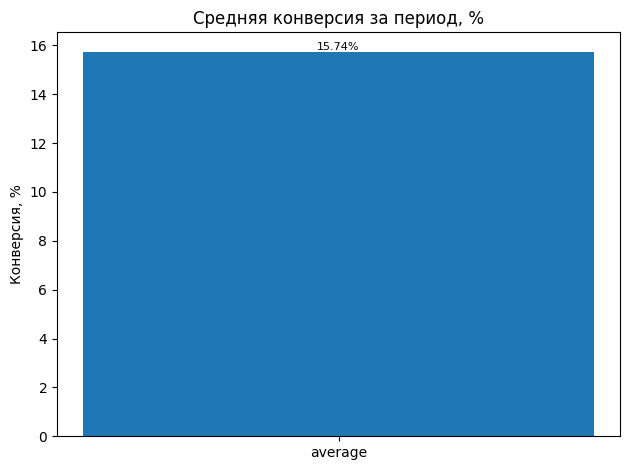

In [34]:
overall_conv = total_regs / total_visits * 100 if total_visits else 0

plt.figure()
ax = plt.gca()
ax.bar(["average"], [overall_conv])
ax.set_title("Средняя конверсия за период, %")
ax.set_ylabel("Конверсия, %")
annotate_bars(ax, fmt="{:.2f}%")
plt.tight_layout()
plt.savefig(CHARTS / "conversion_average.png", dpi=150)
plt.show()


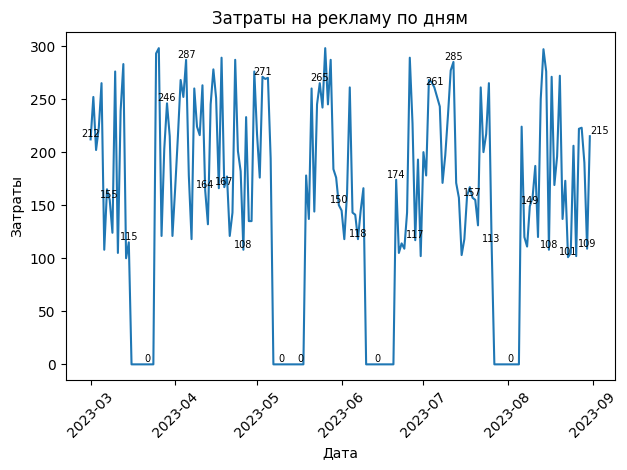

In [35]:
cost_daily = final.groupby("date_group", as_index=False)["cost"].sum()

plt.figure()
ax = plt.gca()
ax.plot(cost_daily["date_group"], cost_daily["cost"])
annotate_points(ax, cost_daily["date_group"], cost_daily["cost"], step=7, fmt="{:,.0f}")
ax.set_title("Затраты на рекламу по дням")
ax.set_xlabel("Дата")
ax.set_ylabel("Затраты")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(CHARTS / "ads_cost_daily.png", dpi=150)
plt.show()


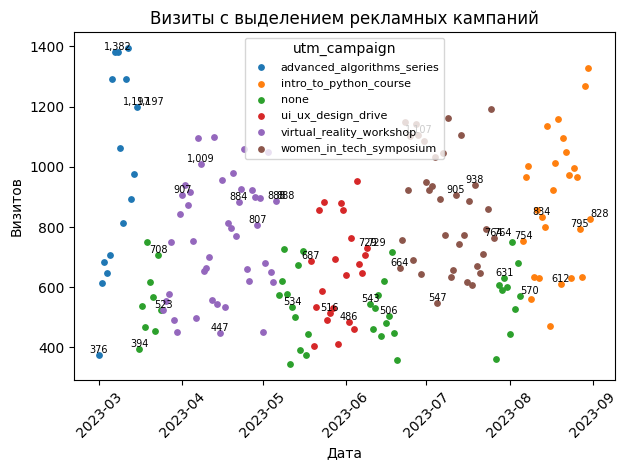

In [36]:
plt.figure()
ax = plt.gca()
for camp, sub in final.groupby("utm_campaign"):
    ax.scatter(sub["date_group"], sub["visits"], label=camp, s=15)
    annotate_points(ax, sub["date_group"], sub["visits"], step=7, fmt="{:,.0f}", fontsize=7)

ax.set_title("Визиты с выделением рекламных кампаний")
ax.set_xlabel("Дата")
ax.set_ylabel("Визитов")
plt.xticks(rotation=45)
ax.legend(title="utm_campaign", fontsize=8)
plt.tight_layout()
plt.savefig(CHARTS / "visits_with_campaigns.png", dpi=150)
plt.show()

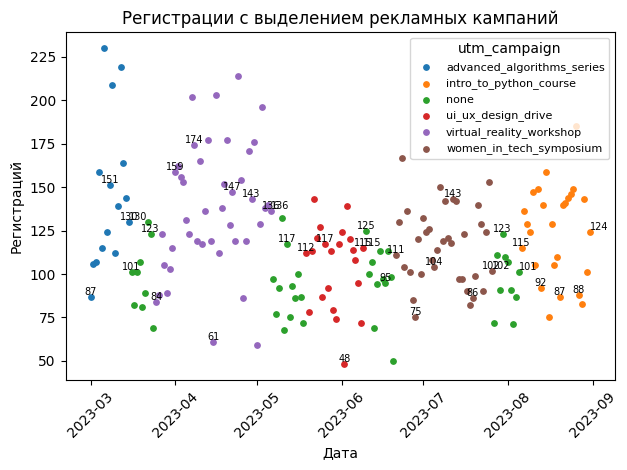

In [61]:
plt.figure()
ax = plt.gca()
for camp, sub in final.groupby("utm_campaign"):
    ax.scatter(sub["date_group"], sub["registrations"], label=camp, s=15)
    annotate_points(ax, sub["date_group"], sub["registrations"], step=7, fmt="{:,.0f}", fontsize=7)

ax.set_title("Регистрации с выделением рекламных кампаний")
ax.set_xlabel("Дата")
ax.set_ylabel("Регистраций")
plt.xticks(rotation=45)
ax.legend(title="utm_campaign", fontsize=8)
plt.tight_layout()
plt.savefig(CHARTS / "registrations_with_campaigns.png", dpi=150)
plt.show()

In [37]:
ls

 ’®¬ ў гбва®©бвўҐ C Ё¬ҐҐв ¬ҐвЄг Windows
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : AEB7-25D4

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\lisol\OneDrive\ђ Ў®зЁ© бв®«\proj3python\data-analytics-project-100

01.09.2025  21:25    <DIR>          .
01.09.2025  21:19    <DIR>          ..
01.09.2025  18:43                85 .env
01.09.2025  15:52    <DIR>          .github
01.09.2025  17:43                40 .gitignore
01.09.2025  20:04    <DIR>          .ipynb_checkpoints
01.09.2025  16:24    <DIR>          .venv
01.09.2025  20:20             9я478 ads.csv
01.09.2025  21:18            14я024 ads.json
01.09.2025  18:29    <DIR>          charts
01.09.2025  21:25           466я068 charts_project.ipynb
01.09.2025  21:16            34я467 conversion.json
01.09.2025  16:09    <DIR>          data
01.09.2025  18:46    <DIR>          notebooks
01.09.2025  15:52               217 README.md
               7 д ©«®ў        524я379 Ў ©в
               8 Ї Ї®Є  379я383я103я488 Ў ©в бў®Ў®¤­®
